In [1]:
# To supress DPT and Mask2Former warnings
import warnings
warnings.filterwarnings("ignore")

import os
import cv2

import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torchvision.transforms.functional as TF

# DPT dependencies for depth pseudo labeling
from pipelines.utils.data_utils import preprocess_multimae_inputs_in_batch
from multimae.utils.plot_utils import plot_predictions, get_semseg_metadata
from multimae.models.multimae import pretrain_multimae_base
from multimae.tools.load_multimae import load_model, multimae_predict

torch.set_grad_enabled(False)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

vb_folder = Path(os.getcwd()) / "vision_backbones"
torch.manual_seed(1) # change seed to resample new mask

In [2]:
model_name = "semseg-clean"
model, args = load_model(model_name)
print(model.output_adapters.keys())

Model loaded from:  /home/chunwei/Documents/drone_offboard/vision_backbones/MultiMAE/results/pretrain/04-04-20-02-36/checkpoint-999.pth
odict_keys(['rgb', 'depth', 'semseg', 'norm_rgb'])


## 3 MultiMAE prediction

Try out MultiMAE by loading any RGB image from a URL using this form:

## get custom test inputs

In [3]:
flightmare_path = Path(os.environ["FLIGHTMARE_PATH"])
data_folder = flightmare_path.parent / "vision_backbones/MultiMAE/datasets/new_env/val"

sample_rgb = data_folder / "rgb/data/000004.png"
sample_depth = data_folder / "depth/data/000004.png"
sample_semseg = data_folder / "semseg/data/000004.png"

pred_save_folder = flightmare_path.parent / "vision_backbones/MultiMAE/results/predictions"

In [4]:
metadata = get_semseg_metadata(data_folder)

(224, 224, 3)
0.0010681315327687496
0.18878461890592813


(-0.5, 639.5, 479.5, -0.5)

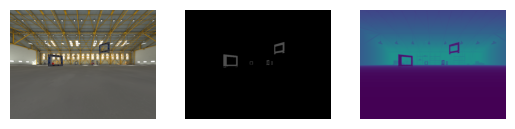

In [5]:
image = cv2.imread(str(sample_rgb))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_float = torch.from_numpy(image).float().permute(2, 0, 1) / 255.0
c, h, w = image_float.shape

image_float = TF.center_crop(image_float, min([h, w]))
image_float = TF.resize(image_float, 224)
image_float = image_float.permute(1, 2, 0).numpy().astype(np.float32)
print(image_float.shape)

image = Image.fromarray(image)

semseg = cv2.imread(str(sample_semseg))
depth = cv2.imread(str(sample_depth), cv2.IMREAD_ANYDEPTH)
depth = depth / 65535.0

print(depth.min())
print(depth.max())

In [ ]:
fig, axs = plt.subplots(1, 3)
axs[0].imshow(image)
axs[0].axis('off')

axs[1].imshow(semseg * 80)
axs[1].axis('off')

axs[2].imshow(depth)
axs[2].axis('off')

Make predictions with a random mask. The mask is sampled during the forward pass and returned, as an output, so you can modify it manually and pass as input (see example below).

In [6]:
# Pre-process RGB, depth and semseg to the MultiMAE input format

input_dict = {
    "rgb": np.expand_dims(image, [0, -1]),
    "depth": np.expand_dims(depth, [0, 3, 4]),
    "semseg": np.expand_dims(semseg[:, :, 0], [0, 3, 4])
}

print(input_dict["rgb"].shape)
print(input_dict["depth"].shape)
print(input_dict["semseg"].shape)

inputs = preprocess_multimae_inputs_in_batch(input_dict, batch_axis=True, hist_axis=True)

inputs = {k: v.squeeze(-1).to("cuda") for k,v in inputs.items()}

print(inputs["rgb"].shape)
print(inputs["depth"].shape)
print(inputs["semseg"].shape)

(1, 480, 640, 3, 1)
(1, 480, 640, 1, 1)
(1, 480, 640, 1, 1)
torch.Size([1, 3, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 56, 56])


tensor(196)
tensor(196)


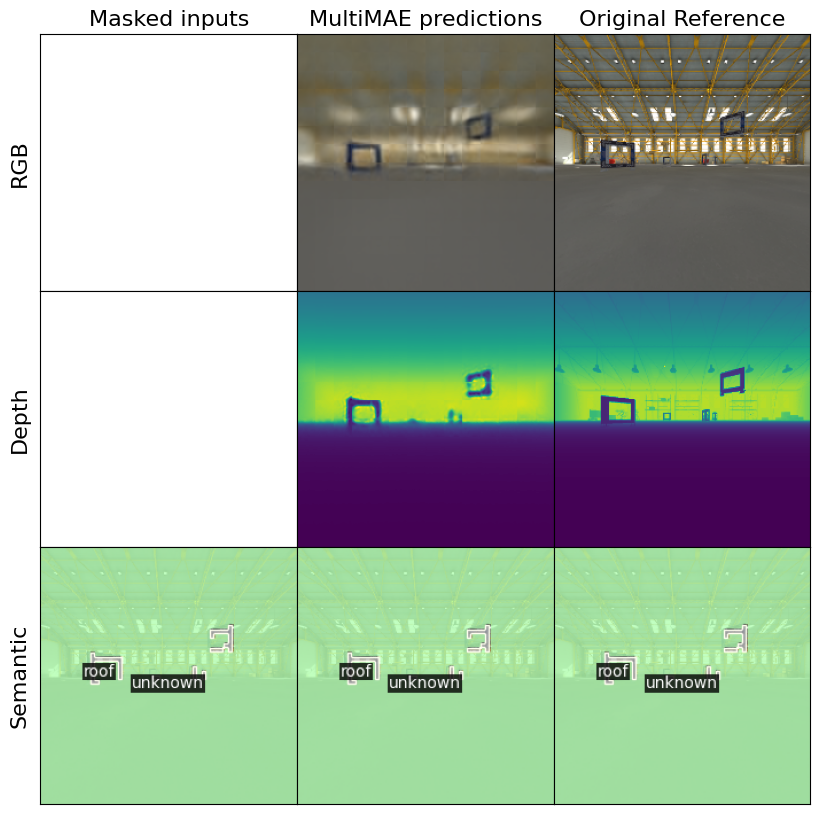

In [7]:
inputs = {k: v.to(device) for k,v in inputs.items()}
in_domains = ["semseg"]

patch_x, patch_y = 14, 14
num_patchs = patch_x * patch_y
num_encoded_tokens = num_patchs * len(in_domains)
B = inputs[in_domains[0]].shape[0]

masks = {
    "rgb": torch.ones((B, num_patchs), dtype=torch.long),
    "depth": torch.ones((B, num_patchs), dtype=torch.long),
    "semseg": torch.zeros((B, num_patchs), dtype=torch.long),
}

masks = {k: torch.LongTensor(v).to(device) for k, v in masks.items()}

preds, masks = model(
    inputs, 
    num_encoded_tokens=num_encoded_tokens, 
    semseg_gt=inputs["semseg"],
    in_domains=in_domains,
    semseg_stride=4, 
    mask_inputs=True,
    task_masks=masks,
    return_embeddings=False
)

preds = {domain: pred.detach().cpu() for domain, pred in preds.items()}
masks = {domain: mask.detach().cpu() for domain, mask in masks.items()}

print(masks["rgb"].sum())
print(masks["depth"].sum())

res = plot_predictions(inputs, preds, masks, metadata=metadata, return_fig=True)

